In [1]:
import csv as csv
import numpy as np
import pandas as pd
import sys
import math
from sklearn import ensemble
from sklearn import linear_model
import sklearn.preprocessing 
import sklearn.cross_validation
import xgboost as xgb
import matplotlib
from sklearn.metrics import mean_squared_error
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier

ImportError: No module named xgboost

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [383]:
# testing data
# Split test / train data 
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    train[train.columns[:-3]],
    train[train.columns[-3:]],
    test_size=0.3)

In [3]:
# write solution 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# prediction 
def get_prediction(features, labels, evaluate_features):
    model = GradientBoostingRegressor(
        n_estimators=200, 
        learning_rate=0.5, 
        max_depth=3, 
        random_state=0,
        loss='ls',
    )
    model.fit(features, labels)
    return model.predict(evaluate_features)

# datetime features
def transform_datetime(feature_data):
    if 'datetime' in feature_data.columns:
        feature_data.datetime = pd.to_datetime(feature_data.datetime)
        feature_data['hour'] = feature_data.datetime.dt.hour
        #feature_data['day'] = feature_data.datetime.dt.day
        feature_data['dayofweek'] = feature_data.datetime.dt.dayofweek
        feature_data.drop('datetime', axis=1, inplace=True)
    return feature_data

def transform_categorical_features(feature_data, feature_names):
    for feature_name in feature_names:
        binary_features = pd.get_dummies(
            feature_data[feature_name], 
            prefix=feature_name,
        )
        feature_data.drop([feature_name], axis=1, inplace=True)
        feature_data[binary_features.columns] = binary_features
    return feature_data 

# specific 
def transform_features(feature_data):
    return transform_categorical_features(
        transform_datetime(feature_data.copy()),
        ['dayofweek', 'season', 'weather', 'hour'],
    )
    
X_train_data = transform_features(train[train.columns[:-3]])
X_test_data = transform_features(transform_datetime(test.copy()))
y_train = train[train.columns[-3:]]

casual_labels = np.log(y_train.casual + 1)
registered_labels = np.log(y_train.registered + 1)

casual_pred = get_prediction(X_train_data, casual_labels, X_test_data)
registered_pred = get_prediction(X_train_data, registered_labels, X_test_data)

count_pred = [math.exp(max(0, x)) - 1 + math.exp(max(0, y)) - 1 
              for x, y in zip(casual_pred, registered_pred)]
print len(count_pred) 

6493


In [438]:
solution = pd.DataFrame({'datetime': test.datetime, 'count': count_pred})
solution.to_csv('prediction_linear_model', index = False, columns=['datetime','count'])

In [318]:
train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16


In [26]:
y_test.head(1)

,casual,registered,count
3463,1,9,10


In [5]:
print train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB
None


In [46]:
# features 
# datetime: bucket 0 -> 23
# season: bucket 1 -> 4
# holiday: binary 0, 1
# working day: work day: monday -> thursday 
# weather: 1 -> 4
# tmp: real number
# output -> causual and register 
targets = train.columns.tolist()[-3:]
feats = train.columns.tolist()[:-3]
print targets
print feats

['casual', 'registered', 'count']
['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']


In [105]:
# feature transform
feature_data = X_train.copy()

In [404]:
feature_data = transform_features(train[train.columns[:-3]])
labels = train[train.columns[-3:]]
# testing data
# Split test / train data 
train_data, test_data, train_labels, test_labels = sklearn.cross_validation.train_test_split(
    feature_data,
    labels,
    test_size=0.2)

print len(train_data.columns)
print len(test_data.columns)
print train_data.columns

45
45
Index([u'holiday', u'workingday', u'temp', u'atemp', u'humidity', u'windspeed',
       u'dayofweek_0', u'dayofweek_1', u'dayofweek_2', u'dayofweek_3',
       u'dayofweek_4', u'dayofweek_5', u'dayofweek_6', u'season_1',
       u'season_2', u'season_3', u'season_4', u'weather_1', u'weather_2',
       u'weather_3', u'weather_4', u'hour_0', u'hour_1', u'hour_2', u'hour_3',
       u'hour_4', u'hour_5', u'hour_6', u'hour_7', u'hour_8', u'hour_9',
       u'hour_10', u'hour_11', u'hour_12', u'hour_13', u'hour_14', u'hour_15',
       u'hour_16', u'hour_17', u'hour_18', u'hour_19', u'hour_20', u'hour_21',
       u'hour_22', u'hour_23'],
      dtype='object')


In [386]:
for ft in X_train_data.columns:
    if ft not in X_test_data.columns:
        print ft 

weather_4


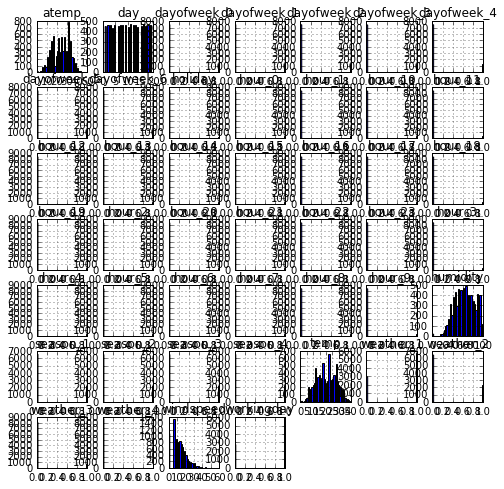

In [378]:
# Visualize
matplotlib.rcParams['figure.figsize'] = (8, 8)
X_train_data.hist(bins=40);

In [394]:
# training model 
casual = GradientBoostingRegressor(
    n_estimators=200, 
    learning_rate=0.5, 
    max_depth=3, 
    random_state=0,
    verbose=1,
    loss='ls',
)
casual_labels = np.log(train_labels.casual + 1)
casual.fit(train_data, casual_labels)
test_casual_labels = np.log(test_labels.casual + 1)
print 'score = ', casual.score(test_data, test_casual_labels)  

      Iter       Train Loss   Remaining Time 
         1           1.5002            1.92s
         2           1.1891            1.97s
         3           0.9645            1.92s
         4           0.8180            1.78s
         5           0.7224            1.62s
         6           0.6416            1.63s
         7           0.5964            1.59s
         8           0.5664            1.52s
         9           0.5325            1.45s
        10           0.5044            1.41s
        20           0.3769            1.19s
        30           0.3268            1.13s
        40           0.2974            1.05s
        50           0.2816            0.98s
        60           0.2698            0.92s
        70           0.2600            0.86s
        80           0.2525            0.79s
        90           0.2441            0.73s
       100           0.2377            0.67s
       200           0.2009            0.00s
score =  0.871487648731


In [5]:
# prediction 
def get_prediction(features, labels, evaluate_features):
    model = xgboost.XGBClassifier()
    model.fit(features, labels)
    return model.predict(evaluate_features)

# testing data
# Split test / train data 
feature_data = transform_features(train[train.columns[:-3]])
labels = train[train.columns[-3:]]
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    feature_data,
    labels,
    test_size=0.2,
)

y_train_data = np.log(y_train.casual + 1)
y_test_data = np.log(y_test.casual + 1) 

predicts = get_prediction(X_train, y_train_data, X_test) 

def label_transform(k):
    return lambda x: np.log(x + k)

def label_transform_reverse(x):
    return lambda x: max(exp.log(x) - k, 0)

def evaluate_model(
    train, 
    model=get_prediction,
):
    # transform features, labels 
    feature_data = transform_features(train[train.columns[:-3]])
    labels = train[train.columns[-3:]]
    # testing data
    # Split test / train data 
    train_data, test_data, train_labels, test_labels = sklearn.cross_validation.train_test_split(
        feature_data,
        labels,
        test_size=0.5,
    )
    
    k = 1
    casual_labels = np.log(train_labels.casual + k)
    registered_labels = np.log(train_labels.registered + k)

    casual_pred = get_prediction(train_data, casual_labels, test_data)
    registered_pred = get_prediction(train_data, registered_labels, test_data)
    
    count_labels = test_labels['count']
    count_pred = [max(np.exp(x) - k, 0) + max(np.exp(y) - k, 0)
                  for x, y in zip(casual_pred, registered_pred)]
    error = mean_squared_error(
        np.log(np.array(count_labels) + 1), 
        np.log(np.array(count_pred) + 1))
    return math.sqrt(error), count_labels, count_pred

error, labels, pred = evaluate_model(train)
print error

NameError: global name 'xgboost' is not defined

In [431]:
i = 0
for x, y in zip(labels, pred):
    i += 1
    print x, y
    if i > 100: break 

93 88.5308837891
42 209.213623047
749 483.161621094
9 290.138671875
9 0
60 54.5450439453
224 309.493164062
561 436.340576172
596 222.448730469
129 142.507568359
460 514.716796875
3 0
21 48.2501220703
188 329.318847656
72 84.8426513672
15 42.4190673828
7 69.4821777344
2 0
408 440.982421875
292 248.618164062
206 206.198120117
154 202.486328125
234 211.323852539
74 77.2529296875
157 233.26953125
382 422.049316406
19 82.8253173828
58 63.7430419922
107 190.805541992
425 204.582763672
12 74.841796875
280 345.988037109
3 40.7630615234
369 320.277709961
181 146.319091797
511 261.573852539
489 332.854858398
146 316.439331055
302 205.038085938
170 252.240722656
58 132.162231445
381 422.894775391
45 72.6820068359
367 277.16027832
38 120.112548828
87 12.1169433594
161 288.667602539
189 226.042602539
132 136.722412109
9 30.6104736328
185 77.4017333984
24 21.5623779297
336 348.363647461
286 251.813476562
5 62.5484619141
92 131.191040039
53 305.106201172
101 362.604736328
3 0
290 209.808105469
408 32

In [285]:
s = np.exp(casual.predict(X_test_data)) - 1 
for i in range(30):
    print y_test.casual.tolist()[i], int(s[i])

41 39
4 6
135 153
6 9
65 52
146 191
22 29
221 172
185 242
0 1
5 14
6 5
7 3
2 1
22 33
160 205
29 27
52 63
0 0
36 21
45 32
58 54
47 24
7 4
47 57
8 14
22 27
1 1
2 7
0 0
